In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import datasets
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
test_dataset_path = "../out/rnn/w2v2base_rnn2_hidden128_drop6/test_result"
model_sfreq = 50
tokenizer_name = "charsiu/tokenizer_en_cmu"

In [3]:
test_dataset = datasets.load_from_disk(test_dataset_path)

In [5]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained(tokenizer_name)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
hidden_state_sources = []
hidden_states = []
for i, item in enumerate(tqdm(test_dataset)):
    hidden_state_sources += [(i, j) for j in range(item["real_frames"])]
    hidden_states.append(np.array(item["rnn_hidden_states"][:item["real_frames"]]))

hidden_states = np.concatenate(hidden_states, axis=0)
assert len(hidden_state_sources) == hidden_states.shape[0]

hidden_state_source_to_flat_idx = {source: i for i, source in enumerate(hidden_state_sources)}

  0%|          | 0/1680 [00:00<?, ?it/s]

In [81]:
boundary_event_names = ["file", "phoneme", "word"]
boundary_event_to_idx = {event_name: i for i, event_name in enumerate(boundary_event_names)}
boundary_matrix = np.zeros((hidden_states.shape[0], len(boundary_event_names)))

def add_boundaries(item, idx, boundary_matrix, boundary_event_to_idx, hidden_state_source_to_flat_idx):
    compression_ratio = item["compression_ratio"]

    file_start_idx = hidden_state_source_to_flat_idx[(idx, 0)]
    boundary_matrix[file_start_idx, boundary_event_to_idx["file"]] = 1

    for word in item["word_phonemic_detail"]:
        if len(word) == 0:
            continue

        word_start = int(word[0]["start"] * compression_ratio)
        word_start_idx = hidden_state_source_to_flat_idx[(idx, word_start)]
        boundary_matrix[word_start_idx, boundary_event_to_idx["word"]] = 1

        for phoneme in word:
            phoneme_start = int(phoneme["start"] * compression_ratio)
            phoneme_start_idx = hidden_state_source_to_flat_idx[(idx, phoneme_start)]
            boundary_matrix[phoneme_start_idx, boundary_event_to_idx["phoneme"]] = 1

    return None

test_dataset.map(add_boundaries, batched=False, with_indices=True,
                 fn_kwargs={"boundary_matrix": boundary_matrix, "boundary_event_to_idx": boundary_event_to_idx,
                            "hidden_state_source_to_flat_idx": hidden_state_source_to_flat_idx})

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'rnn_hidden_states', 'logits', 'distance_from_decision_threshold', 'predicted', 'real_frames', 'labels', 'compression_ratio', 'correct', 'fp', 'fn', 'tp', 'tn', 'accuracy'],
    num_rows: 1680
})

## PCA decomposition and time series analysis

In [82]:
d_pca = 4
pca = PCA(d_pca)
hidden_states_pca = pca.fit_transform((hidden_states - hidden_states.mean(axis=0)) / hidden_states.std(axis=0))

In [83]:
pca.explained_variance_ratio_

array([0.18685624, 0.10967019, 0.04190646, 0.03702973])

### TRF model

In [84]:
from mne.decoding import ReceptiveField
from sklearn.model_selection import train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(boundary_matrix, hidden_states_pca, shuffle=True, test_size=0.2, random_state=42)

In [86]:
trf = ReceptiveField(tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)
trf.fit(X_train, y_train)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

<ReceptiveField | tmin, tmax : (-5.000, 20.000), estimator : <class 'float'>, features : [file, ..., word], fit: True>

In [87]:
trf.score(X_test, y_test)

array([0.38041219, 0.03830228, 0.12231944, 0.2402646 ])

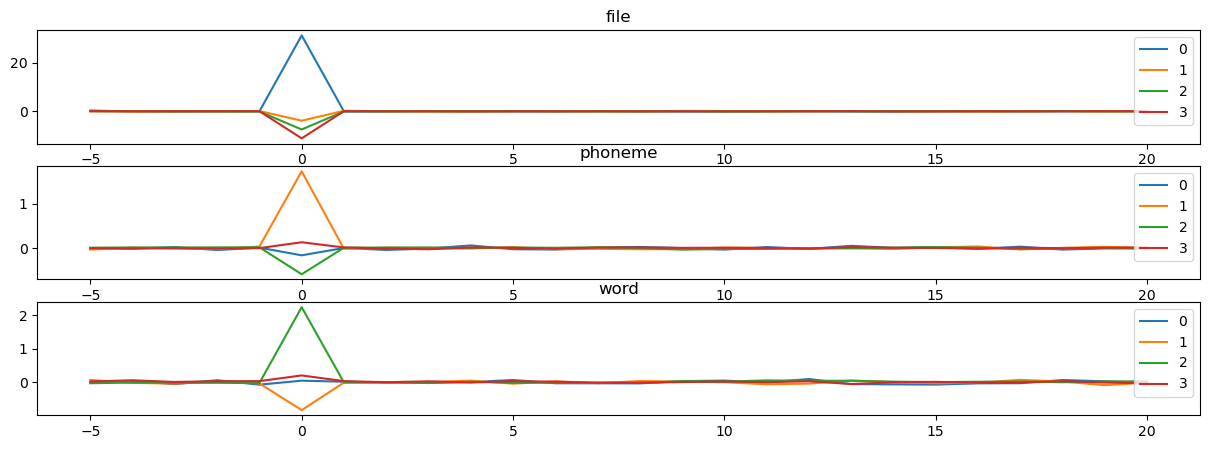

In [88]:
f, axs = plt.subplots(trf.coef_.shape[1], 1, figsize=(5 * trf.coef_.shape[1], 5))
for input_dim, (name, ax) in enumerate(zip(boundary_event_names, axs.ravel())):
    ax.set_title(name)
    for output_dim in range(trf.coef_.shape[0]):
        ax.plot(trf.delays_, trf.coef_[output_dim, input_dim, :], label=output_dim)
        ax.legend()

### Epoched analysis

In [120]:
def epoch_and_plot(epoch_event, hidden_states, boundary_matrix, epoch_window=(-5, 20), baseline_window=(-5, 0)):
    epoch_data = []
    target_width = epoch_window[1] - epoch_window[0]
    for event_idx in tqdm(boundary_matrix[:, boundary_event_to_idx[epoch_event]].nonzero()[0]):
        epoch_states = hidden_states[event_idx + epoch_window[0]:event_idx + epoch_window[1]]

        if baseline_window is not None:
            baseline_states = hidden_states[event_idx + baseline_window[0]:event_idx + baseline_window[1]]
            epoch_states -= baseline_states.mean(axis=0)

        if epoch_states.shape[0] < target_width:
            # Pad
            epoch_states = np.pad(epoch_states, ((0, target_width - epoch_states.shape[0]), (0, 0)))
        epoch_data.append(epoch_states)

    epoch_data = np.array(epoch_data)

    f, ax = plt.subplots(figsize=(10, 5))
    ax.axvline(0, color="gray")
    ax.axhline(0, color="gray")

    for dim in range(epoch_data.shape[2]):
        data = epoch_data[:, :, dim]
        data_mean = data.mean(axis=0)
        data_sem = data.std(axis=0) / np.sqrt(data.shape[0])

        xs = np.arange(epoch_window[0], epoch_window[1]) / model_sfreq
        ax.plot(xs, data_mean, label=dim)
        ax.fill_between(xs, data_mean - data_sem, data_mean + data_sem, alpha=0.3)

    return ax, epoch_data

  0%|          | 0/14546 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Word onset')

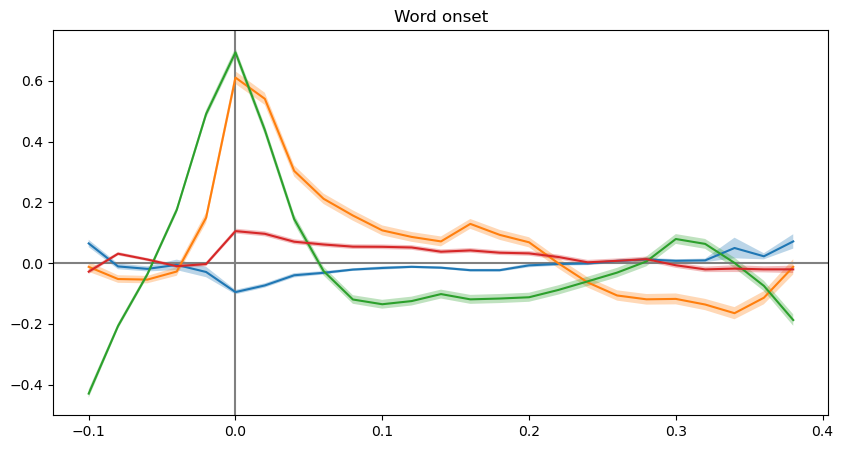

In [121]:
ax, _ = epoch_and_plot("word", hidden_states_pca, boundary_matrix)
ax.set_title("Word onset")

  0%|          | 0/53419 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Phoneme onset')

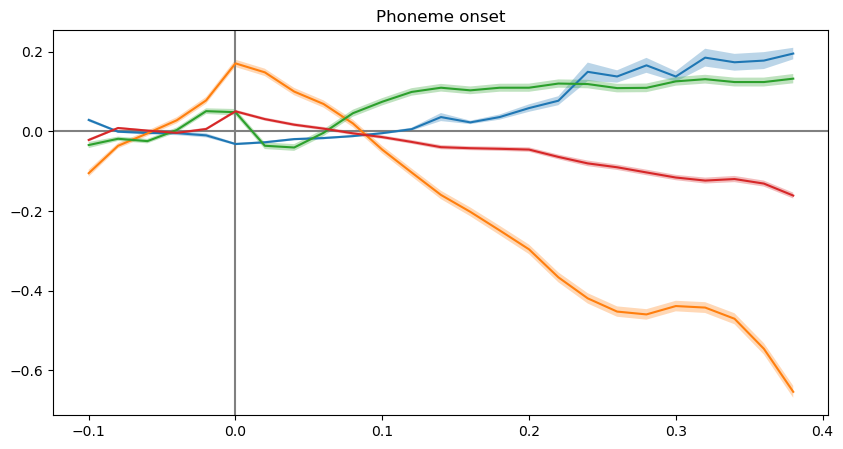

In [122]:
ax, _ = epoch_and_plot("phoneme", hidden_states_pca, boundary_matrix)
ax.set_title("Phoneme onset")

## Norm time series analysis

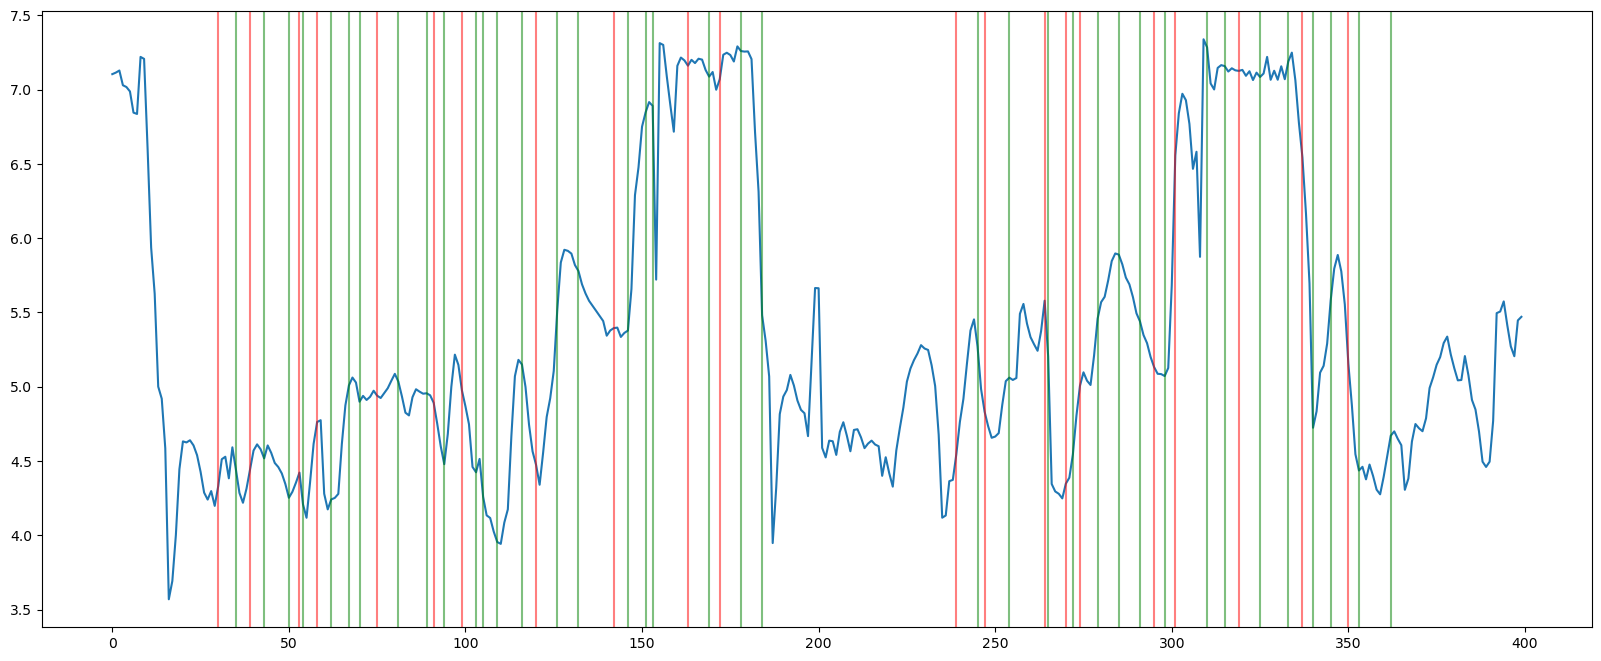

In [113]:
offset = 1000
lim = 400
f, ax = plt.subplots(figsize=(20, 8))
ax.plot(np.linalg.norm(hidden_states, axis=1)[offset:offset + lim])
for word_onset in boundary_matrix[:, boundary_event_to_idx["word"]].nonzero()[0]:
    if word_onset > lim:
        break
    ax.axvline(word_onset, color="red", alpha=0.5)
for phon_onset in boundary_matrix[:, boundary_event_to_idx["phoneme"]].nonzero()[0]:
    if phon_onset > lim:
        break
    if boundary_matrix[phon_onset, boundary_event_to_idx["word"]] == 1:
        continue
    ax.axvline(phon_onset, color="green", alpha=0.5)

In [93]:
trf_norm = ReceptiveField(tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)
boundary_matrix_conj = boundary_matrix.copy()
boundary_matrix_conj[:, boundary_event_to_idx["phoneme"]] = boundary_matrix_conj[:, boundary_event_to_idx["phoneme"]] * (1 - boundary_matrix_conj[:, boundary_event_to_idx["word"]])
norm_X_train, norm_X_test, norm_y_train, norm_y_test = train_test_split(boundary_matrix_conj, np.linalg.norm(hidden_states, axis=1), shuffle=True, test_size=0.1, random_state=42)

In [94]:
trf_norm.fit(norm_X_train, norm_y_train)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

<ReceptiveField | tmin, tmax : (-5.000, 20.000), estimator : <class 'float'>, features : [file, ..., word], fit: True>

In [95]:
trf_norm.score(norm_X_test, norm_y_test)

array([0.02489044])

In [96]:
trf_norm.coef_.shape

(3, 26)

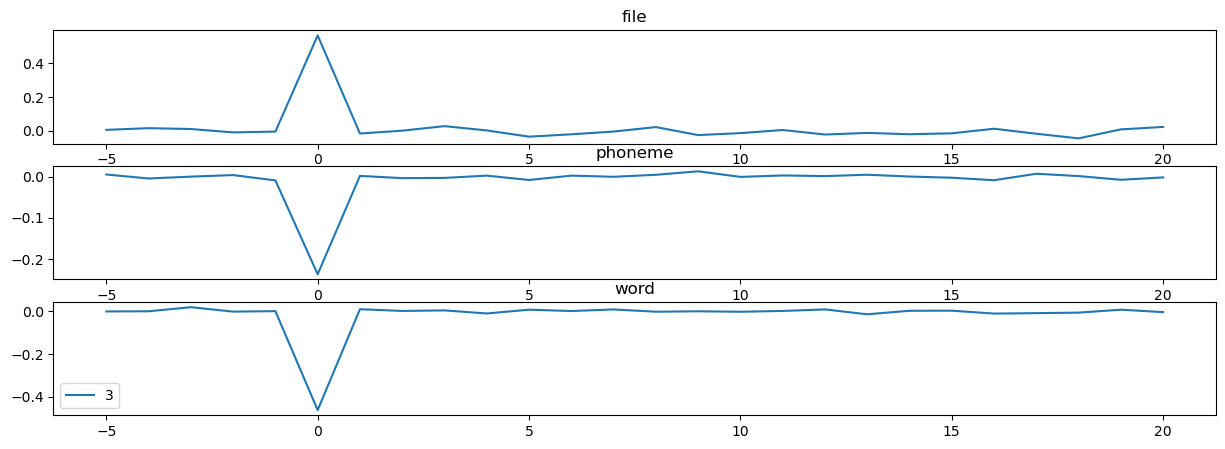

In [97]:
f, axs = plt.subplots(trf_norm.coef_.shape[0], 1, figsize=(5 * trf_norm.coef_.shape[0], 5))
for input_dim, (name, ax) in enumerate(zip(boundary_event_names, axs.ravel())):
    ax.set_title(name)

    ax.plot(trf_norm.delays_, trf_norm.coef_[input_dim, :], label=output_dim)
ax.legend()

  0%|          | 0/14546 [00:00<?, ?it/s]

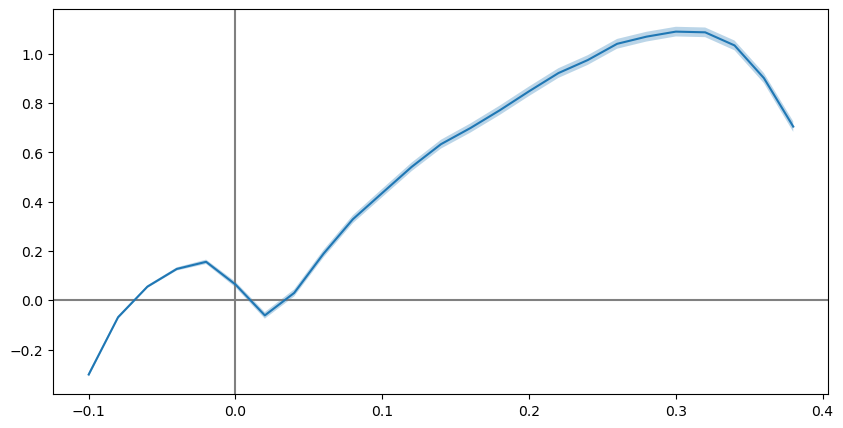

In [126]:
ax, _ = epoch_and_plot("word", np.linalg.norm(hidden_states, axis=1, keepdims=True), boundary_matrix_shift)
None

  0%|          | 0/53419 [00:00<?, ?it/s]

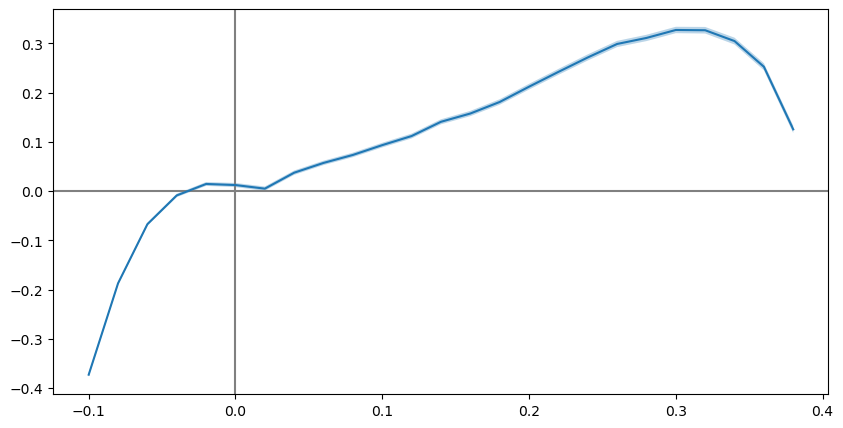

In [125]:
ax, _ = epoch_and_plot("phoneme", np.linalg.norm(hidden_states, axis=1, keepdims=True), boundary_matrix_shift)
None

## PCA decomposition of state transitions

In [102]:
hidden_state_shifts = hidden_states[1:] - hidden_states[:-1]
boundary_matrix_shift = boundary_matrix[1:]

In [104]:
d_pca = 4
shift_pca = PCA(d_pca)
hidden_state_shifts_pca = shift_pca.fit_transform((hidden_state_shifts - hidden_state_shifts.mean(axis=0)) / hidden_state_shifts.std(axis=0))

In [105]:
pca.explained_variance_ratio_

array([0.18685624, 0.10967019, 0.04190646, 0.03702973])

In [106]:
trf_shift = ReceptiveField(tmin=-5, tmax=20, sfreq=1, feature_names=boundary_event_names)
shift_X_train, shift_X_test, shift_y_train, shift_y_test = train_test_split(boundary_matrix_shift, hidden_state_shifts_pca, shuffle=True, test_size=0.2, random_state=42)

In [107]:
trf_shift.fit(shift_X_train, shift_y_train)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

<ReceptiveField | tmin, tmax : (-5.000, 20.000), estimator : <class 'float'>, features : [file, ..., word], fit: True>

In [108]:
trf_shift.score(shift_X_test, shift_y_test)

array([0.24255839, 0.25448531, 0.11035189, 0.06400459])

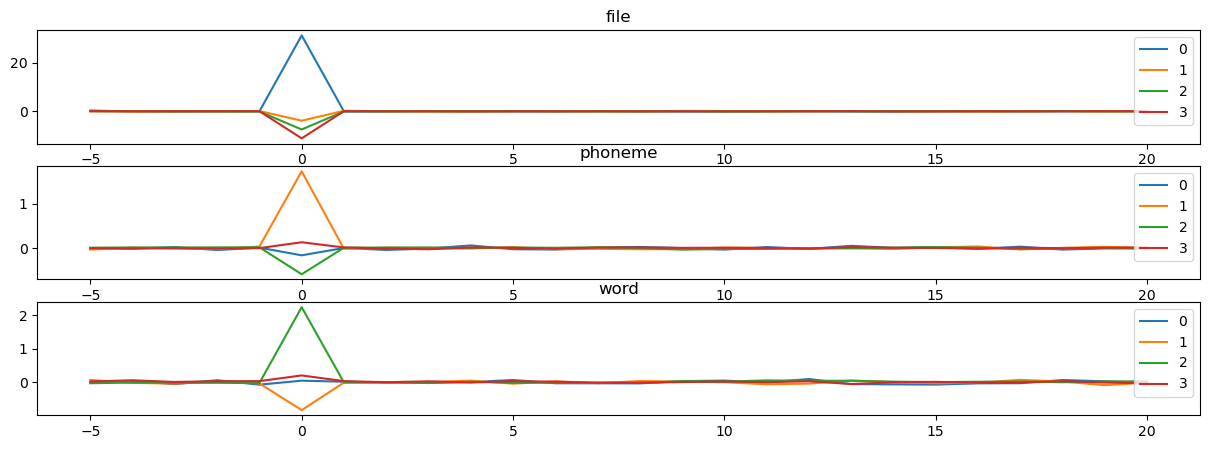

In [109]:
f, axs = plt.subplots(trf.coef_.shape[1], 1, figsize=(5 * trf.coef_.shape[1], 5))
for input_dim, (name, ax) in enumerate(zip(boundary_event_names, axs.ravel())):
    ax.set_title(name)
    for output_dim in range(trf.coef_.shape[0]):
        ax.plot(trf.delays_, trf.coef_[output_dim, input_dim, :], label=output_dim)
        ax.legend()

In [110]:
def epoch_and_plot_shift(epoch_event, epoch_window=(-5, 20), baseline_window=(-5, 0)):
    epoch_data = []
    target_width = epoch_window[1] - epoch_window[0]
    for event_idx in tqdm(boundary_matrix_shift[:, boundary_event_to_idx[epoch_event]].nonzero()[0]):
        epoch_states = hidden_state_shifts_pca[event_idx + epoch_window[0]:event_idx + epoch_window[1]]
        baseline_states = hidden_state_shifts_pca[event_idx + baseline_window[0]:event_idx + baseline_window[1]]
        
        epoch_states -= baseline_states.mean(axis=0)
        if epoch_states.shape[0] < target_width:
            # Pad
            epoch_states = np.pad(epoch_states, ((0, target_width - epoch_states.shape[0]), (0, 0)))
        epoch_data.append(epoch_states)

    epoch_data = np.array(epoch_data)

    f, ax = plt.subplots(figsize=(10, 5))
    ax.axvline(0, color="gray")
    ax.axhline(0, color="gray")

    for dim in range(epoch_data.shape[2]):
        data = epoch_data[:, :, dim]
        data_mean = data.mean(axis=0)
        data_sem = data.std(axis=0) / np.sqrt(data.shape[0])

        xs = np.arange(epoch_window[0], epoch_window[1]) / model_sfreq
        ax.plot(xs, data_mean, label=dim)
        ax.fill_between(xs, data_mean - data_sem, data_mean + data_sem, alpha=0.3)

    return ax, epoch_data

  0%|          | 0/14546 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Word onset')

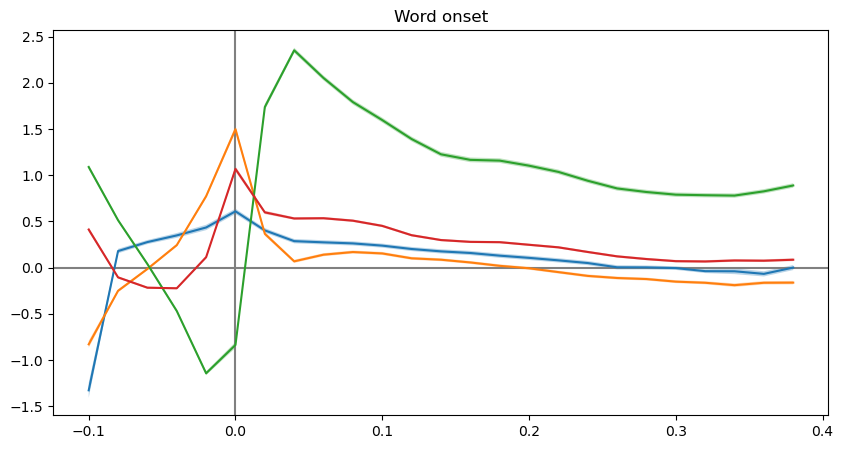

In [111]:
ax, _ = epoch_and_plot_shift("word")
ax.set_title("Word onset")

  0%|          | 0/53419 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Phoneme onset')

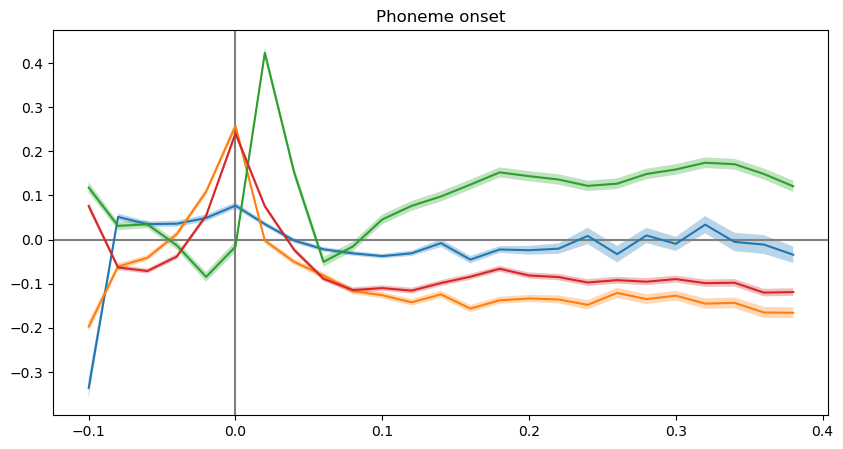

In [112]:
ax, _ = epoch_and_plot_shift("phoneme")
ax.set_title("Phoneme onset")